# Training: Hybrid case

## Preparation

We start by specifying some training hyperparameters and importing NumPy and PyTorch.

In [1]:
BATCH_SIZE = 10
EPOCHS = 15
LEARNING_RATE = 0.1
SEED = 42

In [2]:
import torch
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### Input data

Let's read the data and print some example sentences.

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../examples/datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('../examples/datasets/mc_dev_data.txt')
test_labels, test_data = read_data('../examples/datasets/mc_test_data.txt')

In [ ]:
import os

TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

In [4]:
train_data[:5]

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .']

Targets are represented as 2-dimensional arrays:

In [5]:
train_labels[:5]

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0]]

### Creating and parameterising diagrams

In [6]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Simplify diagrams

In [7]:
from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

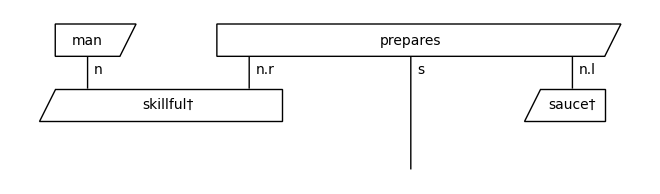

In [8]:
train_diagrams[0].draw()

### Create circuits

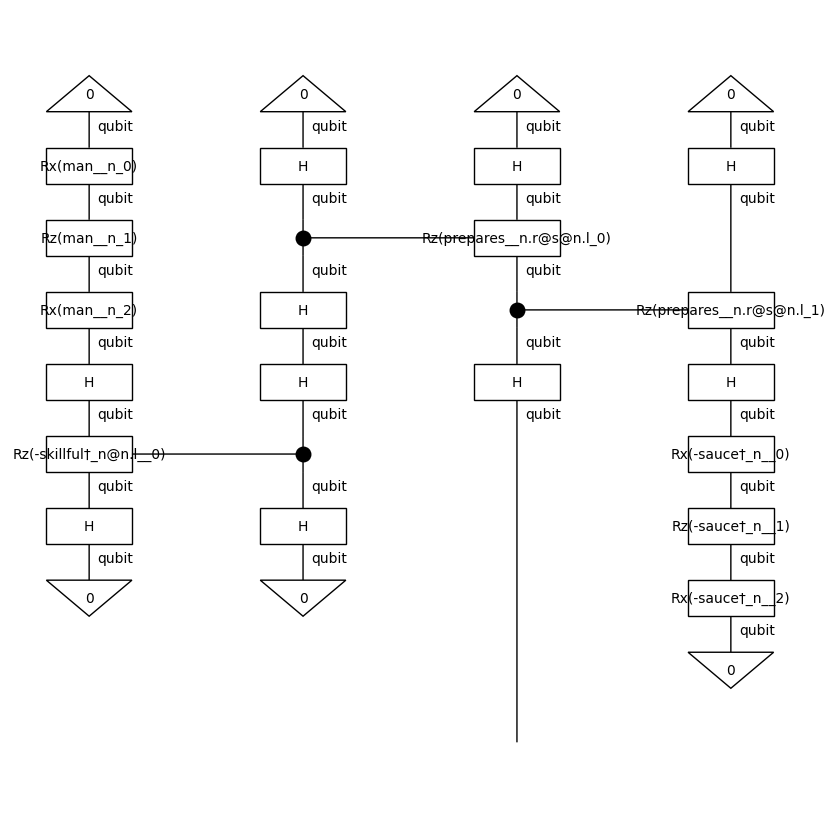

In [9]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(8, 8))

## Training
### Instantiate model

In [10]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + dev_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

### Running on a real quantum computer

In [11]:
import pennylane as qml

qml.default_config['qiskit.ibmq.ibmqx_token'] = 'my_API_token'
qml.default_config.save(qml.default_config.path)
backend_config = {'backend': 'qiskit.ibmq',
                  'device': 'ibmq_manila',
                  'shots': 1000}

In [ ]:
if TESTING:
    backend_config = None

In [12]:
q_model = PennyLaneModel.from_diagrams(all_circuits,
                                       probabilities=True,
                                       normalize=True,
                                       backend_config=backend_config)
q_model.initialise_weights()

In [13]:
qml.default_config['honeywell.global.user_email'] = ('my_Honeywell/Quantinuum_'
                                                     'account_email')
qml.default_config.save(qml.default_config.path)

backend_config = {'backend': 'honeywell.hqs',
                  'device': 'H1-1E',
                  'shots': 1000}

In [ ]:
if TESTING:
    backend_config = None

In [14]:
h_model = PennyLaneModel.from_diagrams(all_circuits,
                                       probabilities=True,
                                       normalize=True,
                                       backend_config=backend_config)
h_model.initialise_weights()

### Create datasets

In [15]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels)

### Define loss and evaluation metric

In [16]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

### Initialise trainer

In [17]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

### Train

In [18]:
trainer.fit(train_dataset, val_dataset)

Epoch 1:   train/loss: 0.1207   valid/loss: 0.0919   train/time: 0.71s   valid/time: 0.16s   train/acc: 0.7857   valid/acc: 0.8667
Epoch 2:   train/loss: 0.0486   valid/loss: 0.1035   train/time: 0.50s   valid/time: 0.17s   train/acc: 0.9286   valid/acc: 0.9000
Epoch 3:   train/loss: 0.0364   valid/loss: 0.0621   train/time: 0.49s   valid/time: 0.17s   train/acc: 0.9429   valid/acc: 0.9333
Epoch 4:   train/loss: 0.0466   valid/loss: 0.0392   train/time: 0.62s   valid/time: 0.18s   train/acc: 0.9857   valid/acc: 1.0000
Epoch 5:   train/loss: 0.0120   valid/loss: 0.0126   train/time: 0.49s   valid/time: 0.18s   train/acc: 0.9857   valid/acc: 1.0000
Epoch 6:   train/loss: 0.0014   valid/loss: 0.0178   train/time: 0.49s   valid/time: 0.17s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 7:   train/loss: 0.0022   valid/loss: 0.0079   train/time: 0.60s   valid/time: 0.17s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 8:   train/loss: 0.0041   valid/loss: 0.0061   train/time: 0.48s   valid/time

## Results

Finally, we visualise the results and evaluate the model on the test data.

Final test accuracy: 0.9666666666666667


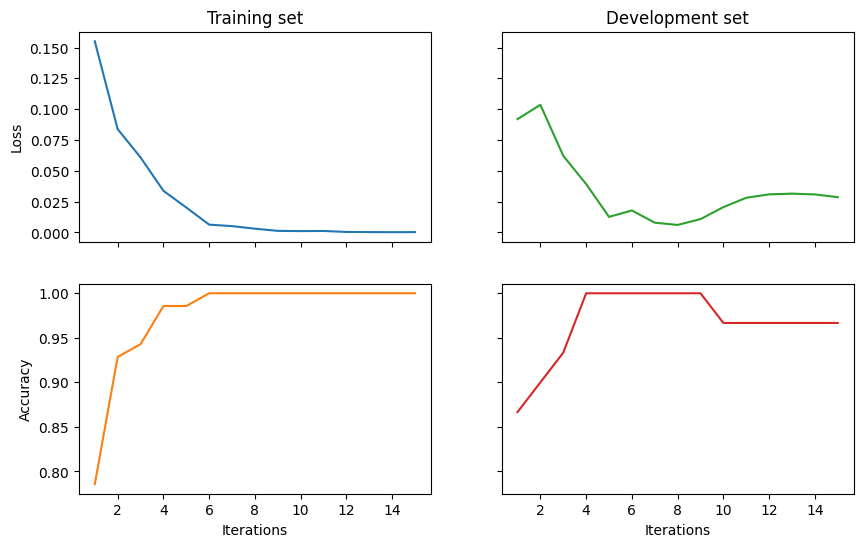

In [19]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

## Using standard PyTorch

As we have a small dataset, we can use early stopping to prevent overfitting to the training data. In this case, we evaluate the performance of the model on the validation dataset every 5 epochs, and save a checkpoint if the validation accuracy has improved. If it does not improve for 10 epochs, we end the training, and load the model with the best validation accuracy.

In [20]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) ==
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

Training is the same as standard PyTorch. We initialize an optimizer, pass it the model parameters, and then run a training loop in which we compute the loss, run a backwards pass to compute the gradients, and then take an optimizer step.

In [21]:
model = PennyLaneModel.from_diagrams(all_circuits)
model.initialise_weights()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_dataset:
        optimizer.zero_grad()
        probs = model(circuits)
        loss = torch.nn.functional.mse_loss(probs,
                                            torch.tensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if i % 5 == 0:
        dev_acc = accuracy(dev_circuits, dev_labels)

        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save('model.lt')
        elif i - best['epoch'] >= 10:
            print('Early stopping')
            break

if best['acc'] > accuracy(dev_circuits, dev_labels):
    model.load('model.lt')

Epoch: 0
Train loss: 1.835998997092247
Dev acc: 0.5333333333333333
Epoch: 5
Train loss: 0.19097438035532832
Dev acc: 0.9
Epoch: 10
Train loss: 0.05956625810358673
Dev acc: 0.9666666666666667


### Evaluate test accuracy

In [22]:
print('Final test accuracy: {}'.format(accuracy(test_circuits, test_labels)))

Final test accuracy: 0.9


## Hybrid models

In [23]:
BATCH_SIZE = 50
EPOCHS = 100
LEARNING_RATE = 0.1
SEED = 2

As the probability outputs from our circuits are guaranteed to be positive, we transform these outputs `x` by `2 * (x - 0.5)`, giving inputs to the neural network in the range [-1, 1]. 

This helps us to avoid "dying ReLUs", which could otherwise occur if all the input weights to a given hidden neuron were negative; in this case, the overall input to the neuron would be negative, and ReLU would set the output of it to 0, leading to the gradient of all these weights being 0 for all samples, causing the neuron to never learn. 

(A couple of alternative approaches could also involve initialising all the neural network weights to be positive, or using `LeakyReLU` as the activation function).

In [24]:
from torch import nn

class XORSentenceModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.xor_net = nn.Sequential(nn.Linear(4, 10),
                                     nn.ReLU(),
                                     nn.Linear(10, 1),
                                     nn.Sigmoid())

    def forward(self, diagram_pairs):
        first_d, second_d = zip(*diagram_pairs)
        evaluated_pairs = torch.cat((self.get_diagram_output(first_d),
                                     self.get_diagram_output(second_d)),
                                    dim=1)
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        return self.xor_net(evaluated_pairs)


### Make paired dataset

Our model is going to determine whether a given pair of sentences are talking about different topics, so we need to construct a dataset of pairs of diagrams for the train, dev, and test data.

In [25]:
from itertools import combinations

def make_pair_data(diagrams, labels):
    pair_diags = list(combinations(diagrams, 2))
    pair_labels = [int(x[0] == y[0]) for x, y in combinations(labels, 2)]
    return pair_diags, pair_labels

train_pair_circuits, train_pair_labels = make_pair_data(train_circuits,
                                                        train_labels)
dev_pair_circuits, dev_pair_labels = make_pair_data(dev_circuits,
                                                    dev_labels)
test_pair_circuits, test_pair_labels = make_pair_data(test_circuits,
                                                      test_labels)

In [26]:
TRAIN_SAMPLES, DEV_SAMPLES, TEST_SAMPLES = 300, 200, 200

In [ ]:
if TESTING:
    TRAIN_SAMPLES, DEV_SAMPLES, TEST_SAMPLES = 1, 1, 1

In [27]:
train_pair_circuits, train_pair_labels = (
    zip(*random.sample(list(zip(train_pair_circuits, train_pair_labels)), 
                       TRAIN_SAMPLES)))
dev_pair_circuits, dev_pair_labels = (
    zip(*random.sample(list(zip(dev_pair_circuits, dev_pair_labels)), DEV_SAMPLES)))
test_pair_circuits, test_pair_labels = (
    zip(*random.sample(list(zip(test_pair_circuits, test_pair_labels)), TEST_SAMPLES)))

### Initialise model

In [28]:
all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

model = XORSentenceModel.from_diagrams(a + b)
model.initialise_weights()
model = model

train_pair_dataset = Dataset(train_pair_circuits,
                             train_pair_labels,
                             batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Train and log accuracies

We train the model using pure PyTorch in the exact same way as above.

In [29]:
def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) ==
            torch.Tensor(labels)).sum().item()/len(circs)

In [30]:
best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)
        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.Tensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_pair_labels)

        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save('xor_model.lt')
        elif i - best['epoch'] >= 10:
            print('Early stopping')
            break

if best['acc'] > accuracy(dev_pair_circuits, dev_pair_labels):
    model.load('xor_model.lt')
    model = model

Epoch: 0
Train loss: 4.291878283023834
Dev acc: 0.53
Epoch: 5
Train loss: 3.321199357509613
Dev acc: 0.55
Epoch: 10
Train loss: 0.38510115444660187
Dev acc: 0.955
Epoch: 15
Train loss: 0.9513051249086857
Dev acc: 0.77
Epoch: 20
Train loss: 4.628978729248047
Dev acc: 0.525
Early stopping


In [31]:
print('Final test accuracy: {}'.format(accuracy(test_pair_circuits,
                                                test_pair_labels)))

Final test accuracy: 0.945


### Analysing the internal representations of the model

We hypothesised that the quantum circuits would be able to separate the representations of sentences about food and cooking, and that the classical NN would learn to XOR these representations to give the model output. Here we can look at parts of the model separately to determine whether this hypothesis was accurate.

First, we can look at the output of the NN when given the 4 possible binary inputs to XOR.

In [32]:
xor_labels = [[1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0]]
# the first two entries correspond to the same label for both sentences, the last two to different labels
xor_tensors = torch.tensor(xor_labels).float()

model.xor_net(xor_tensors).detach().numpy()

array([[0.9993979 ],
       [0.65196735],
       [0.00569755],
       [0.1350544 ]], dtype=float32)

We can see that in the case that the labels are the same, the outputs are significantly greater than 0.5, and in the case that the labels are different, the outputs are significantly less than 0.5, and so the NN seems to have learned the XOR function.

We can also look at the outputs of some of the test circuits to determine whether they have been able to seperate the two classes of sentences.

In [33]:
FOOD_IDX, IT_IDX = 0, 6
symbol_weight_map = dict(zip(model.symbols, model.weights))

In [ ]:
if TESTING: 
    FOOD_IDX, IT_IDX = 0, 0

In [34]:
print(test_data[FOOD_IDX])

p_circ = test_circuits[FOOD_IDX].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(symbol_weight_map)
unnorm = p_circ.eval().detach().numpy()

unnorm / np.sum(unnorm)

woman prepares tasty dinner .


array([0.42397027, 0.57602973])

In [35]:
print(test_data[IT_IDX])

p_circ = test_circuits[IT_IDX].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(symbol_weight_map)
unnorm = p_circ.eval().detach().numpy()

unnorm / np.sum(unnorm)

skillful person runs software .


array([0.95847886, 0.04152114])

From these examples, it seems that the circuits are able to strongly differentiate between the two topics, assigning approximately [0, 1] to the sentence about food, and [1, 0] to the sentence about computing.